In [ ]:
# upgrade scipy to be able to use qmc
# after that automatically restarts the cell
import os
! pip install scipy --upgrade
os.kill(os.getpid(), 9)

In [12]:
import numpy as np
import time
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.stats import qmc

In [13]:
tf.keras.backend.set_floatx("float64")

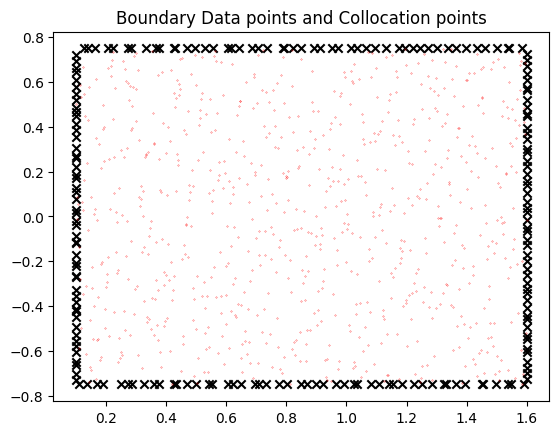

In [14]:
# We a Grad-Shafranov equation -> Delta* u = f(x, y, u) 
# where Delta* is the elliptic laplacian: Delta* u = u_xx - u_x/x + u_yy 
# and f is a function to be specified ........................
# ...............................................................

# Note that Hard constraint for imposing the boundary conditions give much
# better results here ................
#.......................................


### data generation
n_bc = 4
n_data_per_bc = 50
#
# autre cas non linéaire ... voir publications ... (sans ou avec lagaris)
# .................with lagaris is muche better ........

engine = qmc.LatinHypercube(d=1)
data = np.zeros([4,n_data_per_bc , 3])

for i, j in zip(range(n_bc), [0., 1., 0, +1]):
    points = (engine.random(n=n_data_per_bc)[:, 0] - 0.) * 1
    #points = np.linspace(0, +1, n_data_per_bc)
    if i < 2:
        data[i, :, 0] = j + 0.5
        data[i, :, 1] = (points - 0.5)
    else:
        data[i, :, 0] = points + 0.5
        data[i, :, 1] = (j - 0.5)
        
data[0, :, 0] = 0.1
data[1, :, 0] = 1.6
data[0, :, 1] = data[0, :, 1]/0.5*0.75
data[1, :, 1] = data[1, :, 1]/0.5*0.75

data[2, :, 1] = -0.75
data[3, :, 1] = 0.75
data[2, :, 0] = (data[2, :, 0] - 0.5) *1.5 +0.1
data[3, :, 0] = (data[3, :, 0] - 0.5) *1.5 +0.1

# Parameters For the nonlinear source term ......see paper ...
c2=0.2
c1=0.8
sig2=0.005


# BC Values is 0.25 .... see paper
# normalized in [0, 1]
data[0, :, 2] = 0.25
data[1, :, 2] = 0.25
data[2, :, 2] = 0.25
data[3, :, 2] = 0.25

data = data.reshape(n_data_per_bc * n_bc, 3)
#

x_d, y_d, t_d = map(lambda x: np.expand_dims(x, axis=1),                    
                    [data[:, 0], data[:, 1], data[:, 2]])
#
# Colloc data ...................
Nc = 800
engine = qmc.LatinHypercube(d=2)
colloc = engine.random(n=Nc)
colloc = 1 * (colloc -0)

#
colloc[:, 0] = (colloc[:, 0]) * 0.75/0.5 + 0.1
colloc[:, 1] = (colloc[:, 1] -0.5 ) *0.75/0.5

x_c, y_c = map(lambda x: np.expand_dims(x, axis=1), 
               [colloc[:, 0], colloc[:, 1]])

#

plt.title("Boundary Data points and Collocation points")
plt.scatter(data[:, 0], data[:, 1], marker="x", c="k", label="BDP")
plt.scatter(colloc[:, 0], colloc[:, 1], s=.2, marker=".", c="r", label="CP")
plt.show()

#

x_c, y_c, x_d, y_d, t_d =map(lambda x: tf.convert_to_tensor(x,dtype=tf.float64),
                             [x_c, y_c, x_d, y_d, t_d])

In [15]:
### model builder function
def DNN_builder(in_shape=2, out_shape=1, n_hidden_layers=5, 
                neuron_per_layer=20, actfn="tanh"):
    # input layer
    input_layer = tf.keras.layers.Input(shape=(in_shape,))
    # hidden layers
    hidden = [tf.keras.layers.Dense(neuron_per_layer, activation=actfn)(input_layer)]
    for i in range(n_hidden_layers-1):
        new_layer = tf.keras.layers.Dense(neuron_per_layer,
                                          activation=actfn,
                                          activity_regularizer=None)(hidden[-1])
        hidden.append(new_layer)
    # output layer
    output_layer = tf.keras.layers.Dense(1, activation=None)(hidden[-1])
    # building the model
    name = f"DNN-{n_hidden_layers}"
    model = tf.keras.Model(input_layer, output_layer, name=name)
    return model

In [16]:
tf.keras.backend.clear_session()
model = DNN_builder(2, 1, 5, 20, "tanh")
model.summary()
tf.keras.utils.plot_model(model, to_file='model_plot.png', show_shapes=True, 
                          show_layer_names=True, show_dtype=True, 
                          show_layer_activations=True)

Model: "DNN-5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 20)                60        
                                                                 
 dense_1 (Dense)             (None, 20)                420       
                                                                 
 dense_2 (Dense)             (None, 20)                420       
                                                                 
 dense_3 (Dense)             (None, 20)                420       
                                                                 
 dense_4 (Dense)             (None, 20)                420       
                                                                 
 dense_5 (Dense)             (None, 1)                 21    

In [17]:
# um must be used for hard constraints instead of u (for soft ones) ....
@tf.function
def u(x, y):
    u = model(tf.concat([x, y], axis=1))
    return u

@tf.function
def um(x, y):
    um = model(tf.concat([x, y], axis=1))
    um=(x-1.6)*(x-0.1)*(y+0.75)*(y-0.75)*um + 0.25    
    return um

In [18]:
# We define the residual with a non linear source term ....see below (use um or u)
@tf.function
def f(x, y):
    # must be um instead of u for Lagaris BC ...
    u0 = um(x, y)
    u_x = tf.gradients(u0, x)[0]
    u_y = tf.gradients(u0, y)[0]
    u_xx = tf.gradients(u_x, x)[0]
    u_yy = tf.gradients(u_y, y)[0]
    
    F = x*u_xx + x*u_yy - u_x + x *2*x**2*u0*(c2*(1-tf.exp(-u0**2/sig2)))
    F = F + x * 2*x**2*u0*(1/sig2*(c1+c2*u0**2)*tf.exp(-u0**2/sig2))
    
    return tf.reduce_mean(tf.square(F))



In [19]:
@tf.function
def mse(y, y_):
    return tf.reduce_mean(tf.square(y-y_))

    0, 1.85000649
  200, 0.00458185
  400, 0.00380879
  600, 0.00356894
  800, 0.00342404
 1000, 0.00329061
 1200, 0.00315695
 1400, 0.00301971
 1600, 0.00287618
 1800, 0.00272468
 2000, 0.00256523
 2200, 0.00240022
 2400, 0.00223610
 2600, 0.00208395
 2800, 0.00195396
 3000, 0.00184878
 3200, 0.00176391
 3400, 0.00169183
 3600, 0.00162554
 3800, 0.00156117
 4000, 0.00149779
 4200, 0.00143632
 4400, 0.00137870
 4600, 0.00133034
 4800, 0.00128810
 5000, 0.00125236
 5200, 0.00121940
 5400, 0.00118955
 5600, 0.00116056
 5800, 0.00113381
 6000, 0.00110841
 6200, 0.00108440
 6400, 0.00106127
 6600, 0.00103813
 6800, 0.00101607
 7000, 0.00099325
 7200, 0.00096857
 7400, 0.00094280
 7600, 0.00091361
 7800, 0.00088261
 8000, 0.00085860
 8200, 0.00081671
 8400, 0.00078270
 8600, 0.00074829
 8800, 0.00087425
 9000, 0.00067972
 9200, 0.00065228
 9400, 0.00060659
 9600, 0.00055814
 9800, 0.00051774
10000, 0.00048031
10200, 0.00044994
10400, 0.00042482
10600, 0.00040259
10800, 0.00038277
11000, 0.0

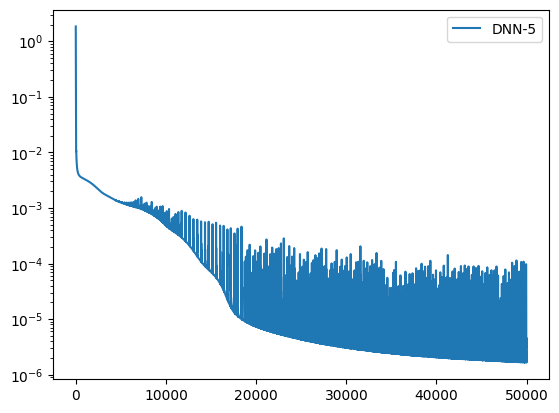

In [20]:
loss = 0
epochs = 50000
opt = tf.keras.optimizers.legacy.Adam(learning_rate=5e-4)
epoch = 0
loss_values = np.array([])
#
start = time.time()
#
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        T_ = u(x_d, y_d)
        L = f(x_c, y_c)
        l = mse(t_d, T_)
        # for lagaris bc ... only L is needed and um intead of u id used above ...
        loss = L 
        
    g = tape.gradient(loss, model.trainable_weights)
    opt.apply_gradients(zip(g, model.trainable_weights))
    loss_values = np.append(loss_values, loss)
    if epoch % 200 == 0 or epoch == epochs-1:
        print(f"{epoch:5}, {loss.numpy():.8f}")

#
end = time.time()
computation_time = {}
computation_time["pinn"] = end - start
print(f"\ncomputation time: {end-start:.3f}\n")
#
plt.semilogy(loss_values, label=model.name)
plt.legend()

In [21]:
n = 100
l = 1.
r = 2*l/(n+1)
T = np.zeros([n*n, n*n])


/var/folders/55/gkf2h_5j4jjgph1cs8cvzd940000gn/T/ipykernel_3471/1534236432.py:41: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/55/gkf2h_5j4jjgph1cs8cvzd940000gn/T/ipykernel_3471/1534236432.py:53: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/var/folders/55/gkf2h_5j4jjgph1cs8cvzd940000gn/T/ipykernel_3471/1534236432.py:70: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


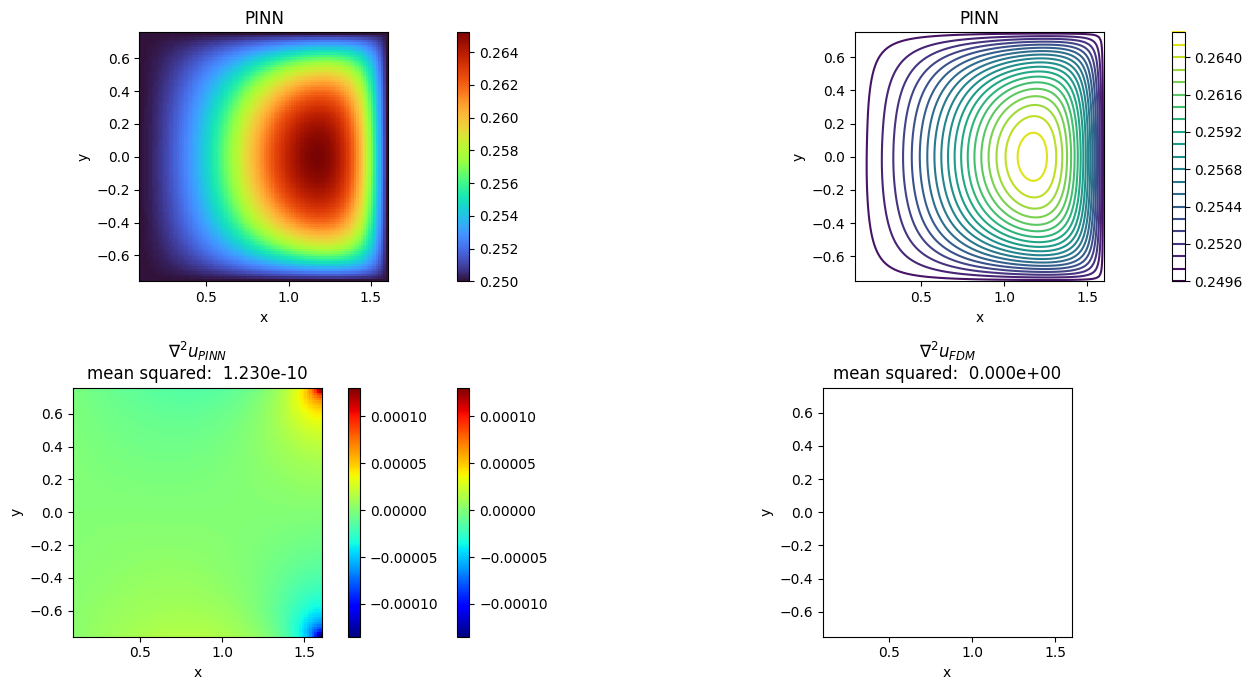

(0.1, 1.6, -0.75, 0.75)

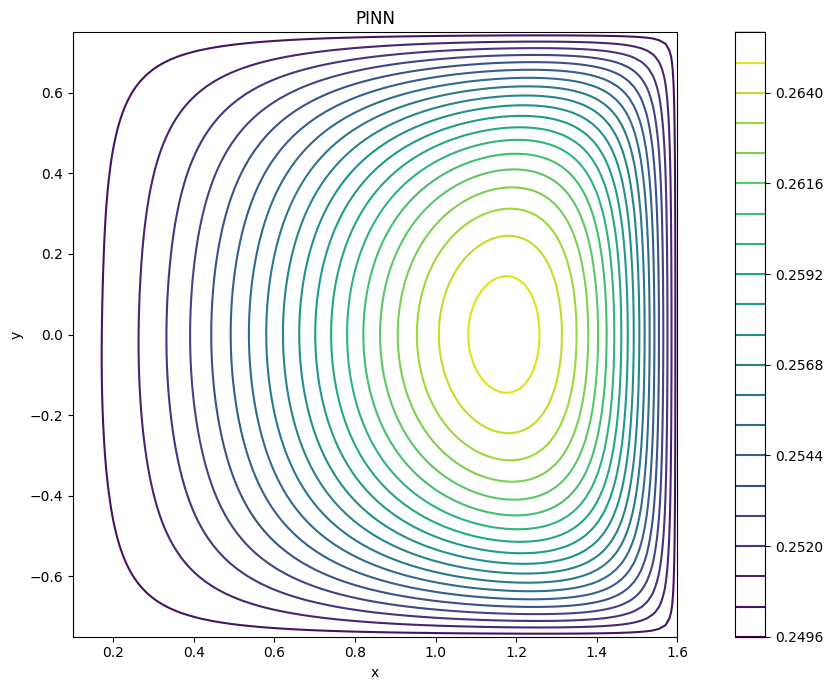

In [22]:
### plotting
#plt.figure("", figsize=(16, 8))
plt.figure("", figsize=(14, 7))
#
X = np.linspace(0.1, +1.6, n)
Y = np.linspace(-0.75, +0.75, n)
X0, Y0 = np.meshgrid(X, Y)
X = X0.reshape([n*n, 1])
Y = Y0.reshape([n*n, 1])
X_T = tf.convert_to_tensor(X)
Y_T = tf.convert_to_tensor(Y)

# um for Lagarics BC only ....... if not (soft constraint) use u instead
S = um(X_T, Y_T)
S = S.numpy().reshape(n, n)
#
plt.subplot(221)
plt.pcolormesh(X0, Y0, S, cmap="turbo")
plt.colorbar(pad=-0.25)
plt.xlabel("x")
plt.ylabel("y")
plt.title("PINN")
plt.tight_layout()
plt.axis("square")
#
x = np.linspace(0.1, 1.6, n)
y = np.linspace(-0.75, 0.75, n)
x, y = np.meshgrid(x, y)


#
plt.subplot(222)
#plt.pcolormesh(x, y, T, cmap="magma")
plt.contour(X0, Y0, S,20)
plt.colorbar(pad=-0.25)
plt.title(r"PINN")
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(0.1, 1.6)
plt.ylim(-0.75, 0.75)
plt.tight_layout()
plt.axis("square")
#plt.savefig("heat01.png")
#
plt.subplot(223)
pinn_grad = np.gradient(np.gradient(S, axis=0), axis=1)
sigma_pinn = (pinn_grad**2).mean()
plt.pcolormesh(X0, Y0, pinn_grad, cmap="jet")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.title(r"${\nabla^{2}{u_{PINN}}}$" + f"\nmean squared: {sigma_pinn: .3e}")
plt.tight_layout()
plt.axis("square")
###
x = np.linspace(0.1, +1.6, n)
y = np.linspace(-0.75, 0.75, n)
x, y = np.meshgrid(x, y)
#
plt.subplot(224)
fdm_grad = np.gradient(np.gradient(T, axis=0), axis=1)
sigma_fdm = (fdm_grad**2).mean()
#plt.pcolormesh(x, y, fdm_grad, cmap="jet")
plt.colorbar()
plt.title(r"${\nabla^{2}{u_{FDM}}}$" + f"\nmean squared: {sigma_fdm: .3e}")
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(0.1, +1.6)
plt.ylim(-0.75, +0.75)
plt.tight_layout()
plt.axis("square")
#plt.savefig("heat01.png")
plt.show()


plt.figure("", figsize=(14, 7))

plt.contour(X0, Y0, S,21)
plt.colorbar(pad=-0.25)
plt.title(r"PINN")
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(0.5, 1.5)
plt.ylim(-0.5, 0.5)
plt.tight_layout()
plt.axis("square")

#

